In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rc('image', cmap='RdBu_r')

In [2]:
import yaml
import math
import copy

import glob
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import pickle as pkl
import itertools as it
from collections import defaultdict
import seaborn
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statistics import NormalDist

from data.dataset import MultiTaskDataset, MultiTaskDataModule
from model.transformer import MultitaskModelModule
import misc.utils as utils
from scripts.main import setup_dataset, setup_model

import wandb
import torch
import torch.nn.functional as F
from einops import rearrange, repeat

In [3]:
api = wandb.Api(timeout=19)
PROJECT = 'effie-li/multitask-transformer-v1'
LOCAL_RUN_ROOT = '/data5/liyuxuan/multitask/multitask-transformer-v1/'
runs, config_list, id_list = utils.fetch_runs(api, PROJECT)

In [4]:
target_runs = {'D2H1': ['3vo5tc2b','2qxt3k1d','37w75pzh','8goxw4zl'],
               'D1H1': ['46cynze6','2c61152w','304au9z0','1ksb97ru'],
               'D1H2': ['1590pwft','4onc1j8l','1dj5ejae','3vogh5rs'],
               'D2H1-sinusoidal': ['2z1c75et','ger4bq28','3syecjmq','1kxx1p9h'],
               'D2H1-learnable': ['1skqn1et','2ij87gcy','2xdiddlt','1qmz3zwx'],
               'D1H1-copy': ['2wr7enwd','2kg80q8z','1ab42shx','r8gszm8l'],
               'D1H1-reverse': ['1byp8fyi','3micvzvn','57fk3ipt','19asya8b'],
               'D2H1-gs': ['2ayyoyr7','1rwnt3z3','pdy98pck','3aarx9pd']
               }

not_finished = []

learning curves

In [6]:
train_lr = {arch:{} for arch in target_runs.keys()}
val_lr = {arch:{} for arch in target_runs.keys()}
for arch in target_runs.keys():
    for runid in target_runs[arch]:
        if runid in not_finished: continue
        train_lr[arch][runid] = utils.get_learning_curve_data(api=api, project=PROJECT, runid=runid, 
                                                              keys=['epoch','trainer/global_step','train/item_acc_epoch','train/label_acc_epoch'])
        train_lr[arch][runid] = train_lr[arch][runid][train_lr[arch][runid]['trainer/global_step'] <= 32129]
        val_lr[arch][runid] = utils.get_learning_curve_data(api=api, project=PROJECT, runid=runid,
                                                            keys=['epoch','trainer/global_step','val/item_acc','val/label_acc'])
        val_lr[arch][runid] = val_lr[arch][runid][val_lr[arch][runid]['trainer/global_step'] <= 32129]

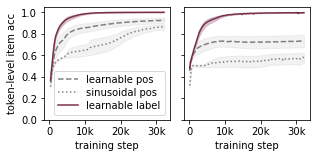

In [90]:
fig, axes = plt.subplots(1, 2, figsize=[4.5,2.3], sharex=True, sharey=True)

colors = {'D2H1':'#782f4d', 'D2H1-sinusoidal': 'gray', 'D2H1-learnable': 'gray'}
labels = {'D2H1': 'learnable label', 'D2H1-sinusoidal': 'sinusoidal pos', 'D2H1-learnable': 'learnable pos'}
linestyles = {'D2H1':'-', 'D2H1-sinusoidal': ':', 'D2H1-learnable': '--'}
alphas = {'D2H1':0.25, 'D2H1-sinusoidal':0.1, 'D2H1-learnable':0.1}

metric = 'item'

for arch in ['D2H1-learnable','D2H1-sinusoidal', 'D2H1']:
    xs = np.array([train_lr[arch][runid]['trainer/global_step'].values for runid in train_lr[arch]])
    ys = np.array([train_lr[arch][runid]['train/%s_acc_epoch'%metric].values for runid in train_lr[arch]])
    utils.plot_line_and_ribbon(axes[0], xs[0], ys, color=colors[arch], label=labels[arch],
                               ls=linestyles[arch], alpha=alphas[arch])

    xs = np.array([val_lr[arch][runid]['trainer/global_step'].values for runid in val_lr[arch]])
    ys = np.array([val_lr[arch][runid]['val/%s_acc'%metric].values for runid in val_lr[arch]])
    utils.plot_line_and_ribbon(axes[1], xs[0], ys, color=colors[arch], label=labels[arch],
                               ls=linestyles[arch], alpha=alphas[arch])

axes[0].legend(loc='lower right', labelspacing=0.3)
axes[0].set_xlabel('training step')
axes[1].set_xlabel('training step')
axes[0].set_ylabel('token-level %s acc'%metric)
axes[0].set_ylim(0,1.05)
# axes[0].set_title('traning: length 5-25')
# axes[1].set_title('generalization: length 26-50')
axes[0].set_xticks([0,10000,20000,30000])
axes[0].set_xticklabels(['0','10k','20k','30k'])
axes[1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])

fig.tight_layout()
# fig.savefig('../figure/v1/single_task_learning_curve_posenc_%s.pdf'%metric)

In [29]:
dfs = []
keys = ['epoch','trainer/global_step', 'val/item_acc', 'val/label_acc']
for arch in target_runs.keys():
    for runid in target_runs[arch]:
        lc = utils.get_learning_curve_data(api=api, project=PROJECT, runid=runid, keys=keys)
        lc = lc[lc['trainer/global_step']<=32129]
        max_row = lc[lc['val/item_acc']==lc['val/item_acc'].max()]
        max_row['arch'] = arch
        max_row['runid'] = runid
        max_row['embed_dim'] = config_list[id_list.index(runid)]['model']['embed_dim']
        max_row['n_head'] = config_list[id_list.index(runid)]['model']['n_heads']
        max_row['depth'] = config_list[id_list.index(runid)]['model']['depth']
        dfs.append(max_row)
df = pd.concat(dfs)

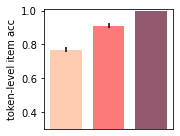

In [46]:
fig, ax = plt.subplots(1, figsize=[2.6,2], sharey=True)

# colors = {'D1H1-copy':'#ffbe9e', 'D1H1-reverse':'#ffbe9e', 'D1H1':'#ffbe9e', 'D1H2':'#fa5a5a', 'D2H1':'#782f4d', 'D2H1-gs':'#782f4d'}
colors = {'D1H1':'#ffbe9e', 'D1H2':'#fa5a5a', 'D2H1':'#782f4d'}
labels = {'D1H1':'[1]', 'D1H2':'[2]', 'D2H1':'[1,1]'}
xs = [0.3,1.1,1.9,3,4.1,4.9]
df_plot = df.groupby('arch').agg([np.mean, sp.stats.sem])

for i, arch in enumerate(colors.keys()):
    ax.bar(xs[i], df_plot['val/item_acc','mean'][arch], yerr=df_plot['val/item_acc','sem'][arch], \
           color=colors[arch], lw=2, width=0.6, alpha=0.8, label=labels[arch])

ax.set_ylabel('token-level item acc')
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

ax.set_ylim([0.3,1.01])
# ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig('../figure/v1/single_task_perf_sort.pdf')

max val performance

In [5]:
max_val_acc_df = pd.read_csv('temp_pkl_files/single_task_max_val_acc.pkl')

In [20]:
max_val_acc_df = []
for arch in target_runs.keys():
    for runid in target_runs[arch]:
        lc = utils.get_learning_curve_data(api=api, project=PROJECT, runid=runid, keys=['epoch','trainer/global_step','val/item_acc','val/label_acc'])
        lc = lc[lc['trainer/global_step']<=33000] # max 32128 training steps for all seeds
        max_row = lc[lc['val/label_acc']==lc['val/label_acc'].max()]
        max_row['runid'] = runid
        max_row['embed_dim'] = config_list[id_list.index(runid)]['model']['embed_dim']
        max_row['arch'] = arch
        max_val_acc_df.append(max_row)
max_val_acc_df = pd.concat(max_val_acc_df)

In [6]:
max_val_acc_df.groupby('arch').agg([np.mean, np.std]).round(4)*100

epoch         trainer/global_step            val/item_acc  \
                 mean     std                mean        std         mean   
arch                                                                        
D1H1-copy     8550.00  297.54          3079938.89  105553.49        99.03   
D1H1-reverse  8216.07  539.96          2959737.50  192644.69        99.75   
D2H1          8533.33  321.46          3075966.67  118838.64        99.57   
D2H1-gs       8850.00  100.00          3186050.00   42470.50        98.41   

                   val/label_acc       embed_dim       
               std          mean   std      mean  std  
arch                                                   
D1H1-copy     0.41        100.00  0.00   12800.0  0.0  
D1H1-reverse  0.21        100.00  0.00   12800.0  0.0  
D2H1          0.06         98.30  0.08   12800.0  0.0  
D2H1-gs       0.32         99.31  0.16   12800.0  0.0

In [ ]:
max_val_acc_df.groupby('arch').agg([np.mean, np.std]).round(4)*100

epoch          trainer/global_step            val/item_acc  \
                   mean      std                mean        std         mean   
arch                                                                           
D1H1             8150.0   858.29          2936150.00  301004.86        76.49   
D1H1-copy        8550.0   297.54          3079938.89  105553.49        99.03   
D1H2             8825.0   150.00          3186025.00   53550.00        91.01   
D2H1             8550.0   264.58          3078950.00   97214.63        99.60   
D2H1-learnable   8750.0   191.49          3154800.00   64162.92        73.15   
D2H1-sinusoidal  7975.0  1517.40          2878125.00  538549.44        57.04   

                       val/label_acc        embed_dim       
                   std          mean    std      mean  std  
arch                                                        
D1H1              2.99         51.75   5.35   18400.0  0.0  
D1H1-copy         0.41        100.00   0.00   12800.0  0.0  
D1H2              2.76         78.02   5.89   18400.0  0.0  
D2H1              0.07         98.41   0.23   12800.0  0.0  
D2H1-learnable   11.65         40.51  14.28   12800.0  0.0  
D2H1-sinusoidal  10.75         16.50   6.52   12800.0  0.0

In [22]:
# max_val_acc_df.to_csv('temp_pkl_files/single_task_max_val_acc.pkl')

length generalization -- token-level accuracy

In [12]:
config = yaml.safe_load(open('../config/v1_3f_st.yaml'))
config['dataset']['fname'] = '/data5/liyuxuan/multitask/dataset/v1/shape5-color5-texture5-task8-N10000-5-25.pkl'
config['dataset']['batch_size'] = 5000
datamodule2 = setup_dataset(config)

In [13]:
runid='3vo5tc2b'
device='cuda:6'
model, datamodule = utils.reconstruct_model_and_dm(local_run_root=LOCAL_RUN_ROOT, 
                                                   runid=runid, 
                                                   config=config_list[id_list.index(runid)],
                                                   train_idx=runs[runs['id']==runid]['data.train_idx'].values[0],
                                                   val_idx=runs[runs['id']==runid]['data.val_idx'].values[0],
                                                   batch_size=5000) # 5000
_ = model.to(device)

In [47]:
for batch_train in datamodule2.train_dataloader(): break
batch_train = utils.batch_to_device(batch_train, device, except_keys=['task'])
batch_train = model.process_batch(batch_train, teacher_forcing=False)
seq_lens_train = model._calc_batch_seq_len(batch_train['src']['item'], teacher_forcing=False)
seq_lens_train = np.array([x.cpu() for x in seq_lens_train])

for batch_val in datamodule.val_dataloader(): break
batch_val = utils.batch_to_device(batch_val, device, except_keys=['task'])
batch_val = model.process_batch(batch_val, teacher_forcing=False)
seq_lens_val = model._calc_batch_seq_len(batch_val['src']['item'], teacher_forcing=False)
seq_lens_val = np.array([x.cpu() for x in seq_lens_val])

In [48]:
x = {'batch_train': batch_train, 'seq_lens_train': seq_lens_train, 'batch_val':batch_val,'seq_lens_val':seq_lens_val}
# pkl.dump(x, open('temp_pkl_files/single_task_ro_train_val_batches_5k.pkl','wb'))

In [ ]:
x = pkl.load(open('temp_pkl_files/single_task_ro_train_val_batches_5k.pkl','rb'))

In [49]:
for runid in target_runs['D2H1']:
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)

    print('rolling out model %s ...'%runid)
    
    with torch.no_grad():
        item_pred, label_pred = model.forward_rollout(batch_train['src'])
    pkl.dump({'item_pred':item_pred, 'label_pred':label_pred}, open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'wb'))
    del item_pred, label_pred

    with torch.no_grad():
        item_pred, label_pred = model.forward_rollout(batch_val['src'])
    pkl.dump({'item_pred':item_pred, 'label_pred':label_pred}, open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'wb'))
    del item_pred, label_pred

rolling out model 3vo5tc2b ...
rolling out model 2qxt3k1d ...
rolling out model 37w75pzh ...
rolling out model 8goxw4zl ...


In [16]:
def get_tf_len_acc(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_train['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    len_acc_dfs = []
    for l in np.unique(seq_lens_train):
        seq_ind = np.where(seq_lens_train==l)[0]
        result_dict =  {'pred': {'item': item_pred[seq_ind], 
                                 'label': label_pred[seq_ind]},
                        'target': {'item': batch_train['target']['item'][seq_ind], 
                                   'label': batch_train['target']['label'][seq_ind]}}
        _, tf_acc = model._calc_loss_acc(result_dict)
        tf_acc = {k:tf_acc[k].cpu().numpy() for k in tf_acc.keys()}
        df = pd.DataFrame.from_dict({k:[tf_acc[k]] for k in tf_acc})
        len_acc_dfs.append(df)
    df_train = pd.concat(len_acc_dfs)
    df_train['seq_len'] = np.unique(seq_lens_train)
    df_train['phase'] = 'train'

    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    len_acc_dfs = []
    for l in np.unique(seq_lens_val):
        seq_ind = np.where(seq_lens_val==l)[0]
        result_dict =  {'pred': {'item': item_pred[seq_ind], 
                                'label': label_pred[seq_ind]},
                        'target': {'item': batch_val['target']['item'][seq_ind], 
                                   'label': batch_val['target']['label'][seq_ind]}}
        _, tf_acc = model._calc_loss_acc(result_dict)
        tf_acc = {k:tf_acc[k].cpu().numpy() for k in tf_acc.keys()}
        df = pd.DataFrame.from_dict({k:[tf_acc[k]] for k in tf_acc})
        len_acc_dfs.append(df)
    df_val = pd.concat(len_acc_dfs)
    df_val['seq_len'] = np.unique(seq_lens_val)
    df_val['phase'] = 'val'
    return pd.concat([df_train, df_val])

In [50]:
dfs = []
for arch in ['D2H1']: #,'D1H2','D1H1']:
    runids = target_runs[arch]
    for i, runid in enumerate(runids):
        epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
        step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
        ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
        model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)

        df = get_tf_len_acc(model, runid, teacher_forcing=False)
        df['runid'] = runid
        df['arch'] = arch
        dfs.append(df)

# token_lvl_acc_df = pd.concat(dfs)
# pkl.dump(token_lvl_acc_df, open('temp_pkl_files/single_task_acc_by_len_token_lvl.pkl','wb'))
# token_lvl_roacc_df = pd.concat(dfs)
# pkl.dump(token_lvl_roacc_df, open('temp_pkl_files/single_task_roacc_by_len_token_lvl.pkl','wb'))

In [47]:
token_lvl_acc_df = pkl.load(open('temp_pkl_files/single_task_acc_by_len_token_lvl.pkl','rb'))

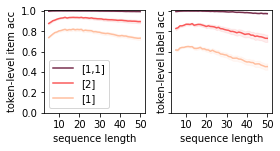

In [77]:
fig, axes = plt.subplots(1, 2, figsize=[4,2.2], sharey=True, sharex=True)

df = token_lvl_acc_df
alpha = 0.8
colors = {'D2H1':'#782f4d', 'D1H2':'#fa5a5a', 'D1H1':'#ffbe9e'}
labels = {'D2H1':'[1,1]', 'D1H2': '[2]', 'D1H1': '[1]'}
w = 0.25

for a, arch in enumerate(['D2H1', 'D1H2', 'D1H1']):
    df_plot = df[df['arch']==arch].groupby(['seq_len']).agg([np.mean, sp.stats.sem]).reset_index()
    for m, metric in enumerate(['item', 'label']):
        axes[m].plot(df_plot['seq_len'].values-1, df_plot['%s_acc'%metric, 'mean'], color=colors[arch], label=labels[arch])
        axes[m].fill_between(df_plot['seq_len'].values-1, 
                             df_plot['%s_acc'%metric,'mean'].values+df_plot['%s_acc'%metric,'sem'].values, 
                             df_plot['%s_acc'%metric,'mean'].values-df_plot['%s_acc'%metric,'sem'].values,  
                             color=colors[arch], alpha=0.1)

axes[0].legend(loc='lower left')
axes[0].set_ylim([0,1.01])
axes[0].set_ylabel('token-level item acc')
axes[1].set_ylabel('token-level label acc')
axes[0].set_xticks([10,20,30,40,50])
axes[0].set_xlabel('sequence length')
axes[1].set_xlabel('sequence length')
axes[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])

fig.tight_layout()
# fig.savefig('../figure/v1/single_task_acc_by_len_token_lvl.pdf')
# fig.savefig('../figure/v1/single_task_roacc_by_len_token_lvl.pdf')

length generalization - sequence-level accuracy

In [30]:
def get_tf_len_acc_seq_lvl(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_train['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    len_acc_dfs = []
    for l in np.unique(seq_lens_train):
        seq_ind = np.where(seq_lens_train==l)[0]
        len_accs = {'item_acc':[], 'label_acc':[]}
        for i in seq_ind: # compute acc for each sequence separately
            result_dict =  {'pred': {'item': item_pred[i:i+1], 
                                    'label': label_pred[i:i+1]},
                            'target': {'item': batch_train['target']['item'][i:i+1], 
                                        'label': batch_train['target']['label'][i:i+1]}}
            _, tf_acc = model._calc_loss_acc(result_dict)
            len_accs['item_acc'].append(tf_acc['item_acc'].cpu())
            len_accs['label_acc'].append(tf_acc['label_acc'].cpu())
        # proportion of sequences that the model got right
        df = pd.DataFrame.from_dict({'item_acc_eq100':[np.mean(np.array(len_accs['item_acc'])==1)],
                                     'label_acc_eq100':[np.mean(np.array(len_accs['label_acc'])==1)],
                                     'item_acc_ge95':[np.mean(np.array(len_accs['item_acc'])>=0.95)],
                                     'label_acc_ge95':[np.mean(np.array(len_accs['label_acc'])>=0.95)],
                                     'item_acc_ge90':[np.mean(np.array(len_accs['item_acc'])>=0.9)],
                                     'label_acc_ge90':[np.mean(np.array(len_accs['label_acc'])>=0.9)]})
        df['seq_len'] = l
        len_acc_dfs.append(df)
    df_train = pd.concat(len_acc_dfs)
    df_train['phase'] = 'train'

    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    len_acc_dfs = []
    for l in np.unique(seq_lens_val):
        seq_ind = np.where(seq_lens_val==l)[0]
        len_accs = {'item_acc':[], 'label_acc':[]}
        for i in seq_ind: # compute acc for each sequence separately
            result_dict =  {'pred': {'item': item_pred[i:i+1], 
                                    'label': label_pred[i:i+1]},
                            'target': {'item': batch_val['target']['item'][i:i+1], 
                                        'label': batch_val['target']['label'][i:i+1]}}
            _, tf_acc = model._calc_loss_acc(result_dict)
            len_accs['item_acc'].append(tf_acc['item_acc'].cpu())
            len_accs['label_acc'].append(tf_acc['label_acc'].cpu())
        # proportion of sequences that the model got right
        df = pd.DataFrame.from_dict({'item_acc_eq100':[np.mean(np.array(len_accs['item_acc'])==1)],
                                     'label_acc_eq100':[np.mean(np.array(len_accs['label_acc'])==1)],
                                     'item_acc_ge95':[np.mean(np.array(len_accs['item_acc'])>=0.95)],
                                     'label_acc_ge95':[np.mean(np.array(len_accs['label_acc'])>=0.95)],
                                     'item_acc_ge90':[np.mean(np.array(len_accs['item_acc'])>=0.9)],
                                     'label_acc_ge90':[np.mean(np.array(len_accs['label_acc'])>=0.9)]})
        df['seq_len'] = l
        len_acc_dfs.append(df)
    df_val = pd.concat(len_acc_dfs)
    df_val['phase'] = 'val'

    return pd.concat([df_train, df_val])

In [ ]:
dfs = []
for arch in ['D2H1','D1H2','D1H1']:
    runids = target_runs[arch]
    for i, runid in enumerate(runids):
        epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
        step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
        ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
        model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
        
        df = get_tf_len_acc_seq_lvl(model, runid, teacher_forcing=False)
        df['runid'] = runid
        df['arch'] = arch
        dfs.append(df)

# seq_lvl_acc_df = pd.concat(dfs)
# pkl.dump(seq_lvl_acc_df, open('temp_pkl_files/single_task_acc_by_len_seq_lvl.pkl','wb'))
seq_lvl_roacc_df = pd.concat(dfs)
# pkl.dump(seq_lvl_roacc_df, open('temp_pkl_files/single_task_roacc_by_len_seq_lvl.pkl','wb'))

In [69]:
seq_lvl_acc_df = pkl.load(open('temp_pkl_files/single_task_acc_by_len_seq_lvl.pkl','rb'))

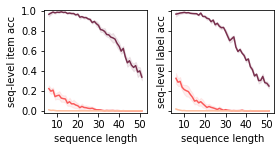

In [79]:
fig, axes = plt.subplots(1, 2, figsize=[4,2.2], sharey=True, sharex=True)

df = seq_lvl_acc_df
threshold = 'eq100'

alpha = 0.8
colors = {'D2H1':'#782f4d', 'D1H2':'#fa5a5a', 'D1H1':'#ffbe9e'}
labels = {'D2H1':'depth=2, head=[1,1]', 'D1H2': 'depth=1, head=[2]', 'D1H1': 'depth=1, head=[1]'}
w = 0.25

for a, arch in enumerate(df['arch'].unique()):
    df_plot = df[df['arch']==arch].groupby(['seq_len']).agg([np.mean, sp.stats.sem]).reset_index()
    for m, metric in enumerate(['item', 'label']):
        axes[m].plot(df_plot['seq_len'], df_plot['%s_acc_%s'%(metric, threshold), 'mean'], color=colors[arch], label=labels[arch])
        axes[m].fill_between(df_plot['seq_len'].values, 
                             df_plot['%s_acc_%s'%(metric, threshold),'mean'].values+df_plot['%s_acc_%s'%(metric, threshold),'sem'].values, 
                             df_plot['%s_acc_%s'%(metric, threshold),'mean'].values-df_plot['%s_acc_%s'%(metric, threshold),'sem'].values,  
                             color=colors[arch], alpha=0.1)

# axes[0].legend(loc='upper left')
axes[0].set_ylim([-0.02,1.01])
axes[0].set_ylabel('seq-level item acc')
axes[1].set_ylabel('seq-level label acc')
axes[0].set_xticks([10,20,30,40,50])
axes[0].set_xlabel('sequence length')
axes[1].set_xlabel('sequence length')
axes[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])

fig.tight_layout()
# fig.savefig('../figure/v1/single_task_acc_by_len_seqlvl_%s.pdf'%threshold)
# fig.savefig('../figure/v1/single_task_roacc_by_len_seqlvl_%s.pdf'%threshold)

length generalization - token-level acc per extrapolation position

In [39]:
def get_tf_pos_acc(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_train['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    item_accs = {p:[] for p in range(50)}
    label_accs = {p:[] for p in range(50)}
    for i in range(len(batch_train['src']['item'])): # for each seq,
        for p in range(seq_lens_train[i]-1): # compute acc for each position separately, ignoring <eos>
            pred, gt = item_pred[i,p], batch_train['target']['item'][i,p] # single token
            acc = (rearrange(pred[-15:], '(f d) -> f d', f=3).argmax(-1)==rearrange(gt[-15:], '(f d) -> f d', f=3).argmax(-1)).float().mean().cpu().numpy()
            item_accs[p].append(acc)
            pred, gt = label_pred[i,p], batch_train['target']['label'][i,p] # single token
            acc = (pred[-50:].argmax()==gt[-50:].argmax()).float().cpu().numpy()
            label_accs[p].append(acc)

    df_train = pd.DataFrame.from_dict({'seq_pos': range(50), 
                                       'item_acc': [np.mean(item_accs[p]) for p in range(50)],
                                       'label_acc': [np.mean(label_accs[p]) for p in range(50)]})
    df_train['phase'] = 'train'
    
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    item_accs = {p:[] for p in range(50)}
    label_accs = {p:[] for p in range(50)}
    for i in range(len(batch_val['src']['item'])): # for each seq,
        for p in range(seq_lens_val[i]-1): # compute acc for each position separately, ignoring <eos>
            pred, gt = item_pred[i,p], batch_val['target']['item'][i,p] # single token
            acc = (rearrange(pred[-15:], '(f d) -> f d', f=3).argmax(-1)==rearrange(gt[-15:], '(f d) -> f d', f=3).argmax(-1)).float().mean().cpu().numpy()
            item_accs[p].append(acc)
            pred, gt = label_pred[i,p], batch_val['target']['label'][i,p] # single token
            acc = (pred[-50:].argmax()==gt[-50:].argmax()).float().cpu().numpy()
            label_accs[p].append(acc)

    df_val = pd.DataFrame.from_dict({'seq_pos': range(50), 
                                     'item_acc': [np.mean(item_accs[p]) for p in range(50)],
                                     'label_acc': [np.mean(label_accs[p]) for p in range(50)]})
    df_val['phase'] = 'val'
    return pd.concat([df_train, df_val])

In [40]:
dfs = []
for arch in ['D2H1','D1H2', 'D1H1']:
    runids = target_runs[arch]
    for i, runid in enumerate(runids):
        epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
        step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
        ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
        model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
        
        df = get_tf_pos_acc(model, runid, teacher_forcing=True)
        df['runid'] = runid
        df['arch'] = arch
        dfs.append(df)

token_acc_by_pos = pd.concat(dfs)
# pkl.dump(token_acc_by_pos, open('temp_pkl_files/single_task_token_acc_by_pos.pkl','wb'))
# token_roacc_by_pos = pd.concat(dfs)
# pkl.dump(token_roacc_by_pos, open('temp_pkl_files/single_task_token_roacc_by_pos.pkl','wb'))

In [63]:
token_acc_by_pos = pkl.load(open('temp_pkl_files/single_task_token_acc_by_pos.pkl','rb'))

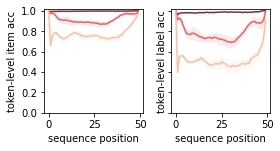

In [82]:
fig, axes = plt.subplots(1, 2, figsize=[4,2.2], sharey=True, sharex=True)

df = token_acc_by_pos
alpha = 0.8
colors = {'D2H1':'#782f4d', 'D1H2':'#fa5a5a', 'D1H1':'#ffbe9e'}
labels = {'D2H1':'depth=2, head=[1,1]', 'D1H2': 'depth=1, head=[2]', 'D1H1': 'depth=1, head=[1]'}
w = 0.25

for a, arch in enumerate(df['arch'].unique()):
    df_plot = df[df['arch']==arch].groupby(['seq_pos']).agg([np.mean, sp.stats.sem]).reset_index()
    for m, metric in enumerate(['item', 'label']):
        axes[m].plot(df_plot['seq_pos'], df_plot['%s_acc'%metric, 'mean'], color=colors[arch], label=labels[arch])
        axes[m].fill_between(df_plot['seq_pos'].values, 
                             df_plot['%s_acc'%metric,'mean'].values+df_plot['%s_acc'%metric,'sem'].values, 
                             df_plot['%s_acc'%metric,'mean'].values-df_plot['%s_acc'%metric,'sem'].values,  
                             color=colors[arch], alpha=0.1)

# axes[0].legend(loc='upper left')
axes[0].set_ylim([0,1.02])
axes[0].set_ylabel('token-level item acc')
axes[1].set_ylabel('token-level label acc')
axes[0].set_xlabel('sequence position')
axes[1].set_xlabel('sequence position')
axes[0].set_xticks([0,25,50])
axes[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])

fig.tight_layout()
# fig.savefig('../figure/v1/single_task_token_acc_by_pos.pdf')
# fig.savefig('../figure/v1/single_task_token_roacc_by_pos.pdf')

length generalization - eos detection

In [ ]:
def get_tf_eos_acc(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_train['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    eos_accs = {p:[] for p in range(5,26)}
    for i in range(len(batch_train['src']['item'])): # for each seq, compute <eos> acc
        p = seq_lens_train[i]-1
        pred, gt = item_pred[i,p], batch_train['target']['item'][i,p] # eos token
        eos_accs[p].append((pred[:2].argmax()==gt[:2].argmax()).float().cpu().numpy())

    df_train = pd.DataFrame.from_dict({'seq_pos': range(5,26), 
                                       'eos_accs': [np.mean(eos_accs[p]) for p in range(5,26)]})
    df_train['phase'] = 'train'

    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    eos_accs = {p:[] for p in range(26,51)}
    for i in range(len(batch_val['src']['item'])): # for each seq, compute <eos> acc
        p = seq_lens_val[i]-1
        pred, gt = item_pred[i,p], batch_val['target']['item'][i,p] # eos token
        eos_accs[p].append((pred[:2].argmax()==gt[:2].argmax()).float().cpu().numpy())

    df_val = pd.DataFrame.from_dict({'seq_pos': range(26,51), 
                                     'eos_accs': [np.mean(eos_accs[p]) for p in range(26,51)]})
    df_val['phase'] = 'val'
    return pd.concat([df_train, df_val])

In [ ]:
dfs = []
for arch in ['D2H1']:
    runids = target_runs[arch]
    for i, runid in enumerate(runids):
        epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
        step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
        ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
        model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
        
        df = get_tf_eos_acc(model, runid, teacher_forcing=False)
        df['runid'] = runid
        df['arch'] = arch
        dfs.append(df)
# eos_acc_by_pos = pd.concat(dfs)
# pkl.dump(eos_acc_by_pos, open('temp_pkl_files/single_task_eos_acc_by_pos.pkl','wb'))
eos_roacc_by_pos = pd.concat(dfs)
pkl.dump(eos_roacc_by_pos, open('temp_pkl_files/single_task_eos_roacc_by_pos.pkl','wb'))

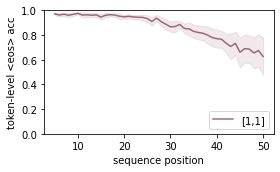

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[4,2.5], sharey=True, sharex=True)

df = eos_roacc_by_pos
alpha = 0.8
colors = {'D2H1':'#782f4d', 'D1H2':'#fa5a5a', 'D1H1':'#ffbe9e'}
labels = {'D2H1':'[1,1]', 'D1H2': '[2]', 'D1H1': '[1]'}
w = 0.25

for a, arch in enumerate(df['arch'].unique()):
    df_plot = df[df['arch']==arch].groupby(['seq_pos']).agg([np.mean, sp.stats.sem]).reset_index()
    ax.plot(df_plot['seq_pos'], df_plot['eos_accs', 'mean'], color=colors[arch], label=labels[arch], alpha=0.7)
    ax.fill_between(df_plot['seq_pos'].values, 
                            df_plot['eos_accs','mean'].values+df_plot['eos_accs','sem'].values, 
                            df_plot['eos_accs','mean'].values-df_plot['eos_accs','sem'].values,  
                            color=colors[arch], alpha=0.1)

ax.legend(loc='lower right')
ax.set_ylim([0,1])
ax.set_ylabel('token-level <eos> acc')
ax.set_xticks([10,20,30,40,50])
ax.set_xlabel('sequence position')

fig.tight_layout()
# fig.savefig('../figure/v1/single_task_token_eos_roacc_by_pos.pdf')

attention maps

In [91]:
target_runs

{'D2H1': ['3vo5tc2b', '2qxt3k1d', '37w75pzh', '8goxw4zl'],
 'D1H1': ['46cynze6', '2c61152w', '304au9z0', '1ksb97ru'],
 'D1H2': ['1590pwft', '4onc1j8l', '1dj5ejae', '3vogh5rs'],
 'D2H1-sinusoidal': ['2z1c75et', 'ger4bq28', '3syecjmq', '1kxx1p9h'],
 'D2H1-learnable': ['1skqn1et', '2ij87gcy', '2xdiddlt', '1qmz3zwx'],
 'D1H1-copy': ['2wr7enwd', '2kg80q8z', '1ab42shx', 'r8gszm8l'],
 'D1H1-reverse': ['1byp8fyi', '3micvzvn', '57fk3ipt', '19asya8b'],
 'D2H1-gs': ['2ayyoyr7', '1rwnt3z3', 'pdy98pck', '3aarx9pd'],
 'D2H1-copy': ['27v7nnfi', '33bir894', '3hs78agd', '3q3o8ahx'],
 'D2H1-reverse': ['9ntbqsou', 'b0rvalt5', '173pcy8f', '3i1bgw38'],
 'D1H2-copy': ['jg0i2is6', '26vkvxaj', 'afqzgb64', '46vjotlk'],
 'D1H2-reverse': [],
 'D1H2-gs': []}

In [10]:
device='cuda:3'
runid='3vo5tc2b' # target_runs['D2H1'][0]
model, datamodule = utils.reconstruct_model_and_dm(local_run_root=LOCAL_RUN_ROOT, 
                                                   runid=runid, 
                                                   config=config_list[id_list.index(runid)],
                                                   train_idx=runs[runs['id']==runid]['data.train_idx'].values[0],
                                                   val_idx=runs[runs['id']==runid]['data.val_idx'].values[0])
# model = setup_model(config_list[id_list.index(runid)]) # random initialization
_ = model.to(device)

In [11]:
for batch in datamodule.val_dataloader(): break
tasks = batch['task']
batch = utils.batch_to_device(batch, device, except_keys=['task'])
batch = model.process_batch(batch, teacher_forcing=True)

In [16]:
def extract_and_reorder_attn_maps(model, batch, batch_idx):

    '''
    plots the attention weights for one sequence in batch, 
    query (y-axis) starts from the <eos> after input seq (first query) and ends at the last item in output seq (last query)
    source includes both input and output sequences
    '''

    depth = model.hparams.depth
    n_head = model.hparams.n_heads
    n_task = model.hparams.n_task
    n_feature = model.hparams.n_feature
    include_task_token = model.hparams.use_task_token

    if type(n_head)==int: n_head = [n_head]*depth

    # extract one sequence at batch_idx as a batch
    seq_lens = model._calc_batch_seq_len(batch['src']['item'], teacher_forcing=True)
    seq_len = seq_lens[batch_idx]
    mini_batch = {'src': {'item': batch['src']['item'][batch_idx:batch_idx+1, :seq_len*2], # (1, seq_len*2, item_dim)
                          'label': batch['src']['label'][batch_idx:batch_idx+1, :seq_len*2]}}

    # generate first-level labels and sort index (used to label items and reorder attention maps for viz)
    if not include_task_token:
        seq = rearrange(mini_batch['src']['item'][0,:seq_len,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
        sorted_seq = rearrange(mini_batch['src']['item'][0,seq_len:seq_len*2,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
    else:
        seq = rearrange(mini_batch['src']['item'][0,1:seq_len,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
        sorted_seq = rearrange(mini_batch['src']['item'][0,seq_len+1:seq_len*2,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
    sort_idx = [seq.cpu().numpy().tolist().index(sorted_item) for sorted_item in sorted_seq.cpu().numpy().tolist()] # include <eos>

    attention_maps = model.get_attention_maps(mini_batch, batch_processed=True, teacher_forcing=True) # list of (1, n_head, seq_len*2, seq_len*2)
    attention_maps = [x[0] for x in attention_maps] # list of (n_head, seq_len*2, seq_len*2)

    reordered_maps = {}
    for l in range(depth):
        for h in range(n_head[l]):

            maps = attention_maps[l][h, :].cpu() # (n_item*2, n_item*2)
            if not include_task_token:
                maps[:seq_len,:seq_len] = maps[:seq_len,:seq_len][sort_idx,:][:,sort_idx] # unsorted portion attending to unsorted portion
                maps[seq_len:,:seq_len] = maps[seq_len:,:seq_len][:,sort_idx] # sorted portion attending to unsorted portion
            else:
                maps[1:seq_len,1:seq_len] = maps[1:seq_len,1:seq_len][sort_idx,:][:,sort_idx]
                maps[seq_len+1:, 1:seq_len] = maps[seq_len+1:, 1:seq_len][:,sort_idx]
            reordered_maps['L%d-H%d'%(l,h)] = maps #[seq_len-1:2*seq_len-1, :]

    return reordered_maps, sorted_seq # sorted_seq does not include task token

def plot_attn_maps(model, batch, batch_idx, task_str, figsize):

    reordered_attn_maps, sorted_seq = extract_and_reorder_attn_maps(model, batch, batch_idx)

    depth = model.hparams.depth
    n_head = model.hparams.n_heads
    if type(n_head)==int: n_head = [n_head]*depth
    n_task = model.hparams.n_task
    n_feature = model.hparams.n_feature
    include_task_token = model.hparams.use_task_token
    task_str = tasks[0]

    fig, axes = plt.subplots(1, sum(n_head), figsize=figsize)

    for l in range(depth):
        for h in range(n_head[l]):
            ax = axes[sum(n_head[:l])+h]
            # ax = axes
            ax.set_title('L%d-H%d'%(l,h))

            im=ax.imshow(reordered_attn_maps['L%d-H%d'%(l,h)], cmap='RdBu_r', vmin=0, vmax=1, norm=mplcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1))
            # if ax==axes[-1]:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='2%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
            seq_len = len(sorted_seq)
            ax.set_xticks(range(0,seq_len*2))
            ax.set_yticks(range(0,seq_len))

            cluster = sorted_seq[:,0].cpu().numpy()
            cluster[-1] = 9
            begin_of_cluster = np.unique(cluster, return_index=True)[1].tolist()

            if include_task_token:
                ax.set_xticks([0]+[1+x for x in begin_of_cluster]+[seq_len+1]+[seq_len+2+x for x in begin_of_cluster])
                # ax.set_yticks([0]+[1+x for x in begin_of_cluster]+[seq_len+1]+[seq_len+2+x for x in begin_of_cluster])
                ax.set_yticks([0]+[1+x for x in begin_of_cluster])
                labels = ['t'] + [str(cluster[i]+1) for i in begin_of_cluster]
                labels[-1] = 'e'
                ax.set_xticklabels(labels*2)
                labels[0] = 't  '
                ax.set_yticklabels(labels)
            else:
                ax.set_xticks([x for x in begin_of_cluster]+[seq_len+x for x in begin_of_cluster])
                ax.set_yticks([x for x in begin_of_cluster]+[seq_len+x for x in begin_of_cluster])
                ax.set_xticklabels(['1','2','3','4','5','e','1','2','3','4','5','e'])
                ax.set_yticklabels(['1','2','3','4','5','e','1','2','3','4','5','e'])
                # ax.set_yticks([0] + [x for x in begin_of_cluster])
                # labels = [str(cluster[i]+1) for i in begin_of_cluster]
                # labels[-1] = 'e'
                # ax.set_xticklabels(labels*2)
                # labels[-1] = 'e  '
                # ax.set_yticks([0]+[x+1 for x in begin_of_cluster[:-1]])
                # ax.set_yticklabels(labels[-1:]+labels[:-1])

            ax.set_ylabel('queries')
            ax.set_xlabel('sources')
    
    # axes[0].set_ylabel('query item')
    # axes[0].set_xlabel('source item')
    # axes[1].set_ylabel('query item')
    # axes[1].set_xlabel('source item')

    # fig.suptitle('depth: %d    '%depth+' n_heads: %s    '%str(np.array(n_head))+'task: '+task_str)
    # fig.subplots_adjust(wspace=-0.5)
    fig.tight_layout()

    return fig, ax

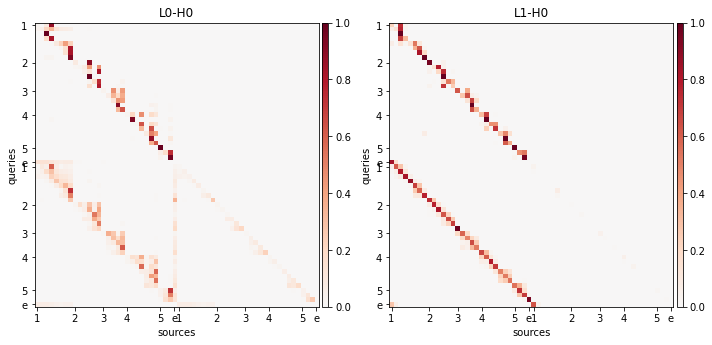

In [18]:
i = 1
fig, ax = plot_attn_maps(model, batch, batch_idx=i, task_str=tasks[i], figsize=[10,5])

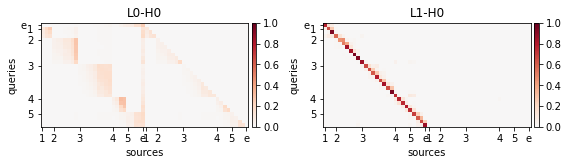

In [ ]:
i = 9 # val example, #3aarx9pd model learning sort_by_shape
fig, ax = plot_attn_maps(model, batch, batch_idx=i, task_str=tasks[i], figsize=[8,2.7])
# fig.savefig('../figure/v1/%s/%s_attn_maps_%d.pdf'%(runid,'val',i))

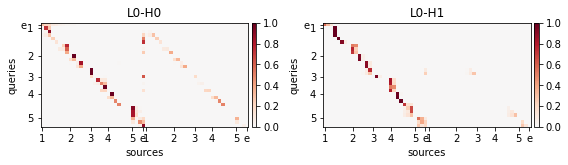

In [47]:
i = 1
fig, ax = plot_attn_maps(model, batch, batch_idx=i, task_str=tasks[i], figsize=[8,2.7])
# fig.savefig('../figure/v1/single_task_D1H2_attn_map_oneseq.pdf')

In [ ]:
mode = 'val'
dataloader = datamodule.train_dataloader if mode=='train' else datamodule.val_dataloader
for batch in dataloader(): break
tasks = batch['task']
batch = utils.batch_to_device(batch, device, except_keys=['task'])
batch = model.process_batch(batch, teacher_forcing=True)
for i in np.random.choice(np.arange(0,len(batch['src']['item'])),10,replace=False):
    fig, axes = plot_attn_maps(model, batch, batch_idx=i, task_str=tasks[i], figsize=[8,6])
    # fig.savefig('../figure/v1/%s/%s_attn_maps_%d.pdf'%(runid,mode,i))
    plt.close(fig)

aggregated features on attention maps (validation sequences)

In [6]:
def get_model_aggregated_attn_features(model):
    seq_lens = model._calc_batch_seq_len(batch['src']['item'], teacher_forcing=True)
    weights_to_eos = {}
    weights_to_items = {}
    for l in range(model.hparams.depth):
        for h in range(model.hparams.n_heads):
            weights_to_eos['L%d-H%d'%(l,h)] = np.zeros((len(batch['src']['item']), 125))
            weights_to_items['L%d-H%d'%(l,h)] = np.zeros((len(batch['src']['item']), 25, 25)) # max 25 items in any cluster

    for batch_idx in range(len(batch['src']['item'])):
        
        seq_len = seq_lens[batch_idx]
        mini_batch = {'src': {'item': batch['src']['item'][batch_idx:batch_idx+1, :seq_len*2], # (1, seq_len*2, item_dim)
                            'label': batch['src']['label'][batch_idx:batch_idx+1, :seq_len*2]}}

        # generate first-level labels and sort index (used to label items and reorder/reshape attention weights for viz)
        seq = rearrange(mini_batch['src']['item'][0,:seq_len,model.hparams.n_task+1:], 'l (f d) -> l f d', f=model.hparams.n_feature).argmax(-1)
        sorted_seq = rearrange(mini_batch['src']['item'][0,seq_len:seq_len*2,model.hparams.n_task+1:], 'l (f d) -> l f d', f=model.hparams.n_feature).argmax(-1)
        cluster = sorted_seq[:,0].cpu().numpy() # first dim for the sort_by_shape task
        cluster[-1] = 9
        begin_of_cluster = np.unique(cluster, return_index=True)[1]
        sort_idx = [seq.cpu().numpy().tolist().index(sorted_item) for sorted_item in sorted_seq.cpu().numpy().tolist()] # include <eos>

        # get attention maps
        attention_maps = model.get_attention_maps(mini_batch, batch_processed=True, teacher_forcing=True) # list of (batch, n_head, n_item, n_item)
        attention_maps = [x[0].cpu() for x in attention_maps] # list of (n_head, n_item, n_item)
        # reorder the portion representing the randomized input sequence
        for l in range(model.hparams.depth):
            for h in range(model.hparams.n_heads):
                # reorder the portion representing the randomized input sequence
                attention_maps[l][h][:seq_len,:seq_len] = attention_maps[l][h][:seq_len,:seq_len][:,sort_idx][sort_idx,:] # unsorted portion attending to unsorted portion (not vized)
                attention_maps[l][h][seq_len:,:seq_len] = attention_maps[l][h][seq_len:,:seq_len][:,sort_idx] # sorted portion attending to unsorted portion

        # for each layer x head, extract and/or re-align attention weights for aggregation across sequences
        for l in range(model.hparams.depth):
            for h in range(model.hparams.n_heads):

                '''
                find attention to <eos>, right-aligning the queries in each cluster
                '''
                # take queries from all items, seq_len:-1 (excluding the first <eos> query at seq_len-1) in row dimension
                # and attention to the <eos> right after the unsorted portion is at seq_len-1 in col dimension
                w = attention_maps[l][h][seq_len:-1, seq_len-1]
                # break weights by each cluster
                w_by_cluster = []
                for c in range(5):
                    cluster_pos = np.where(cluster==c)[0]
                    if c in cluster: w_by_cluster.append(w[cluster_pos[0]:cluster_pos[-1]+1])
                    else: w_by_cluster.append(torch.tensor([float('nan')]))
                # pad and cat so that the weights in each cluster is right-aligned to the cluster <eos>
                w_by_cluster = torch.cat([F.pad(x, pad=(25-len(x), 0), value=float('nan')) for x in w_by_cluster]) # max of (25) items before reaching actual <eos>
                weights_to_eos['L%d-H%d'%(l,h)][batch_idx] = w_by_cluster.numpy()

                '''
                find attention to items within cluster, right-aligning weights
                '''
                # take queries from all items to source of all items + <eos>
                w = attention_maps[l][h][seq_len:-1,:seq_len]
                # break weights by each cluster
                w_within_cluster = []
                for c in range(5):
                    if c in cluster:
                        cluster_pos = np.where(cluster==c)[0]
                        x = w[cluster_pos[0]:cluster_pos[-1]+1,cluster_pos[0]:cluster_pos[-1]+1] # attention from query items to source items (will exclude <eos>)
                        w_within_cluster.append(x)
                    else: 
                        w_within_cluster.append(torch.tensor([[float('nan')]]))
                # pad and stack so that the weights in each cluster is right-aligned then can be averaged
                w_within_cluster = [F.pad(x, pad=(25-x.shape[1], 0, 25-x.shape[0], 0), value=float('nan')) for x in w_within_cluster] # pad left and up to (25, 25)
                w_within_cluster = np.nanmean(torch.stack(w_within_cluster).numpy(), 0) # mean over clusters
                weights_to_items['L%d-H%d'%(l,h)][batch_idx] = w_within_cluster

    return weights_to_eos, weights_to_items

In [ ]:
from model.transformer import MultitaskModelModule

weights_to_eos_all = {}
weights_to_items_all = {}
for runid in target_runs['D2H1']:
    ckptf = LOCAL_RUN_ROOT + '/' + runid + '/checkpoints/last.ckpt'
    model = utils.load_model(MultitaskModelModule, ckptf)
    model.to(device)
    weights_to_eos, weights_to_items = get_model_aggregated_attn_features(model)
    weights_to_eos_all[runid] = weights_to_eos
    weights_to_items_all[runid] = weights_to_items

In [ ]:
weights_to_eos = np.array([weights_to_eos_all[runid]['L0-H0'] for runid in weights_to_eos_all.keys()])
weights_to_eos.shape # (n_run, batch_size, 125)

(4, 1000, 125)

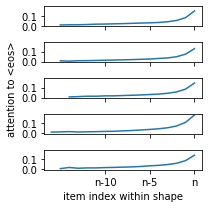

In [ ]:
fig, axes = plt.subplots(5, figsize=[3,3], sharex=True, sharey=True)

weights = np.nanmean(weights_to_eos.reshape((4,1000,5,25)), 1) # mean over batch (n_run, 5, 25)

for i in range(5):
    axes[i].plot(range(25), np.nanmean(weights[:,i], 0))

axes[0].set_yticks([0.0,0.1])
axes[2].set_ylabel('attention to <eos>')
axes[-1].set_xticks([14, 19, 24])
axes[-1].set_xticklabels(['n-10','n-5','n'])
axes[-1].set_xlabel('item index within shape')
# axes[0].set_title('L0-H0')

fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig('../figure/v1/single_task_D2H1_attn_to_eos.pdf')

In [ ]:
weights_to_items = np.array([weights_to_items_all[runid]['L0-H0'] for runid in weights_to_items_all.keys()])
weights_to_items.shape # (n_run, batch_size, 25, 25)

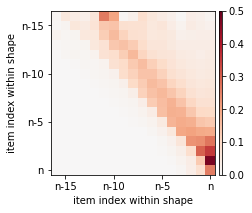

In [ ]:
# attention to items in the same shape cluster
fig, ax = plt.subplots(1, figsize=[3.6,3.6])

weights = np.nanmean(np.nanmean(weights_to_items, 1), 0) # mean over batch and runs
im = ax.imshow(weights[8:,8:], # trim NaNs, turns out the max cluster length is 17 in the dataset
         cmap='RdBu_r', vmin=0, vmax=0.5, norm=mplcolors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)) 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

_ = ax.set_xticks([1,6,11,16])
_ = ax.set_xticklabels(['n-15','n-10','n-5','n'])
_ = ax.set_yticks([1,6,11,16])
_ = ax.set_yticklabels(['n-15','n-10','n-5','n'])
ax.set_ylabel('item index within shape')
ax.set_xlabel('item index within shape')

fig.tight_layout()
# fig.savefig('../figure/v1/single_task_D2H1_attn_within_cluster.pdf')

encoded item representations

In [6]:
def embedding_matrix_to_dataframe(tasks, model, batch, encoded_reps):
    # extract item embeddings in the model for each seq x task x layer
    dfs = []
    n_tasks = model.hparams.n_task
    embed_dim = model.hparams.embed_dim
    for i in range(len(batch['seq'])): # go through each sequence
        task = tasks[i]
        seq_len = int(sum(batch['seq'][i].sum(-1)!=0)) - 1 # counting <eos> and not counting <task>

        # mark boundary items
        tokens = batch['seq'][i][1:1+seq_len-1,n_tasks+1:].cpu().reshape(seq_len-1,3,5).argmax(-1) # all items without eos
        sorted_tokens = batch['out_seq'][i][1:1+seq_len,n_tasks+1:].cpu().reshape(seq_len,3,5).argmax(-1) # all items + <eos>
        cluster = sorted_tokens[:,0].cpu().numpy()
        cluster[-1] = 9
        begin_of_cluster = np.unique(cluster, return_index=True)[1].tolist()
        boundary = ['begin' if i in begin_of_cluster and i != seq_len-1 else 'end' if i+1 in begin_of_cluster else 'other' for i in range(seq_len)]
        # sorted_tokens_list = [list(token) for token in sorted_tokens]
        # source_boundary = [boundary[sorted_tokens_list.index(list(tokens[i]))] for i in range(seq_len-1)]

        # source seq (contains only items, no eos)
        token_types = np.array(['item']*(seq_len-1))
        labels = batch['random_label'][i,1:1+seq_len-1,n_tasks+1:].argmax(-1).cpu()
        sort_idx = batch['sort_idx'][i,1:1+seq_len-1,n_tasks+1:].argmax(-1).cpu()
        # extract source embeddings and reorder
        input_embed = encoded_reps['input_embed'][i,:seq_len-1].cpu()
        l0_embed = encoded_reps['attn_embed'][0,i,:seq_len-1].cpu()
        l1_embed = encoded_reps['attn_embed'][1,i,:seq_len-1].cpu()
        input_embed = input_embed[sort_idx]
        l0_embed = l0_embed[sort_idx]
        l1_embed = l1_embed[sort_idx]
        tokens = tokens[sort_idx]
        labels = labels[sort_idx]
        # put in a df
        df = pd.DataFrame(torch.cat([input_embed, l0_embed, l1_embed])) # (3*seq_len-1, embed_dim)
        df['seq'] = [i]*(3*seq_len-3)
        df['task'] = [task]*(3*seq_len-3)
        df['layer'] = np.repeat(['input','L0','L1'], seq_len-1)
        df['source_probe_target'] = ['source']*(3*seq_len-3)
        df['item_type'] = np.tile(token_types, 3)
        df['out_pos'] = list(range(seq_len-1))*3 
        df['boundary'] = np.tile(boundary[:-1], 3)
        df['shape'] = np.tile(tokens[:,0], 3)
        df['color'] = np.tile(tokens[:,1], 3)
        df['texture'] = np.tile(tokens[:,2], 3)
        df['label'] = np.tile(labels, 3)
        dfs.append(df)

        # query seq (labeled as input token, starts with eos)
        labels = batch['sorted_label'][i,1:1+seq_len,n_tasks+1:].argmax(-1).cpu()
        tokens = torch.cat((sorted_tokens[-1:], sorted_tokens[:-1])) # shift eos to start
        labels = torch.cat((labels[-1:], labels[:-1])) # shift eos to start
        token_types = ['eos'] + ['item']*(seq_len-1)
        # extract query embeddings
        input_embed = encoded_reps['input_embed'][i,seq_len-1:2*seq_len-1].cpu()
        l0_embed = encoded_reps['attn_embed'][0,i,seq_len-1:2*seq_len-1].cpu()
        l1_embed = encoded_reps['attn_embed'][1,i,seq_len-1:2*seq_len-1].cpu()
        # put in a df
        df = pd.DataFrame(torch.cat([input_embed, l0_embed, l1_embed])) # (3*seq_len, embed_dim)
        df['seq'] = [i]*(3*seq_len)
        df['task'] = [task]*(3*seq_len)
        df['layer'] = np.repeat(['input','L0','L1'], seq_len)
        df['source_probe_target'] = ['probe']*(3*seq_len)
        df['item_type'] = np.tile(token_types, 3)
        df['out_pos'] = ([''] + list(range(seq_len-1)))*3 # list(range(seq_len))*3
        df['boundary'] = np.tile(boundary[-1:] + boundary[:-1], 3)
        df['shape'] = np.tile(tokens[:,0], 3)
        df['color'] = np.tile(tokens[:,1], 3)
        df['texture'] = np.tile(tokens[:,2], 3)
        df['label'] = np.tile(labels, 3)
        dfs.append(df)

        # query seq (labeled as output token, ends with eos)
        labels = batch['sorted_label'][i,1:1+seq_len,n_tasks+1:].argmax(-1).cpu()
        token_types = ['item']*(seq_len-1) + ['eos']
        # extract query embeddings
        input_embed = encoded_reps['input_embed'][i,seq_len-1:2*seq_len-1].cpu()
        l0_embed = encoded_reps['attn_embed'][0,i,seq_len-1:2*seq_len-1].cpu()
        l1_embed = encoded_reps['attn_embed'][1,i,seq_len-1:2*seq_len-1].cpu()
        # put in a df
        df = pd.DataFrame(torch.cat([input_embed, l0_embed, l1_embed])) # (3*seq_len, embed_dim)
        df['seq'] = [i]*(3*seq_len)
        df['task'] = [task]*(3*seq_len)
        df['layer'] = np.repeat(['input','L0','L1'], seq_len)
        df['source_probe_target'] = ['target']*(3*seq_len)
        df['item_type'] = np.tile(token_types, 3)
        df['out_pos'] = (list(range(seq_len-1)) + [''])*3# list(range(seq_len))*3
        df['boundary'] = np.tile(boundary, 3)
        df['shape'] = np.tile(sorted_tokens[:,0], 3)
        df['color'] = np.tile(sorted_tokens[:,1], 3)
        df['texture'] = np.tile(sorted_tokens[:,2], 3)
        df['label'] = np.tile(labels, 3)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df[['seq','task','layer','source_probe_target','item_type','out_pos','boundary','shape','color','texture','label']+list(range(embed_dim))]
    return df

In [7]:
max_val_acc_df[max_val_acc_df['arch']=='D2H1']

,Unnamed: 0,epoch,trainer/global_step,val/item_acc,val/label_acc,runid,embed_dim,arch
0,168,84,30165,0.996274,0.982715,3vo5tc2b,128,D2H1
1,179,89,32128,0.995793,0.983864,2qxt3k1d,128,D2H1
2,167,83,29986,0.995071,0.982420,37w75pzh,128,D2H1
3,159,79,28558,0.997120,0.985698,8goxw4zl,128,D2H1


In [7]:
device='cuda:5'
runid='8goxw4zl' # target_runs['D2H1'][0]
config = config_list[id_list.index(runid)]
config['dataset']['split_params']['val_count'] = 100000
dataset = MultiTaskDataset(config)
# hacky way to sample a batch of specific length
config['dataset']['split_params']['train_range'] = [30, 30]
datamodule = MultiTaskDataModule(dataset=dataset, 
                                 batch_size=500, 
                                 split_params=config['dataset']['split_params'])
for batch in datamodule.train_dataloader(): break
tasks = batch['task']
batch = utils.batch_to_device(batch, device, except_keys=['task'])

In [8]:
runid='8goxw4zl'
# load max val acc ckpt
epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
with torch.no_grad():
    result_dict = model.forward(batch)
    loss_dict, acc_dict = model._calc_loss_acc(result_dict)
print(loss_dict, acc_dict)
# get encoded token representations
encoded_reps = model.get_encoded_reps(batch, batch_processed=False, teacher_forcing=True)
print(encoded_reps['input_embed'].shape)
print(encoded_reps['attn_embed'].shape)
embedding_df = embedding_matrix_to_dataframe(tasks, model, batch, encoded_reps)

{'item_loss': tensor(0.0052, device='cuda:5'), 'label_loss': tensor(0.0250, device='cuda:5')} {'item_acc': tensor(0.9983, device='cuda:5'), 'label_acc': tensor(0.9911, device='cuda:5')}
torch.Size([500, 102, 128])
torch.Size([2, 500, 102, 128])


SVD

In [9]:
def svd(data):
    data = data - data.mean(0) # center the data
    u, s, v = np.linalg.svd(data, full_matrices=False)
    print('SVD shapes: u.shape=%s, s.shape=%s, v.shape=%s' % (u.shape, s.shape, v.shape))
    return (u, s, v)

In [12]:
# input embeddings - complete
all_items = list(it.product(range(5),range(5),range(5)))
all_items_multihot = torch.stack([torch.cat( (torch.tensor([0,0]), 
                                            F.one_hot(torch.tensor(x).unsqueeze(-1), num_classes=5).view(-1)) ) 
                                for x in all_items])
all_labels = F.pad(F.one_hot(torch.arange(50), 50), pad=(2,0), value=0)

item_embeddings = []
label_embeddings = []
input_embeddings = []
for x in all_items_multihot:
    for l in all_labels:
        embeddings = model.transformer.item_embed(x.float().to(model.device)).detach().cpu().numpy() + \
                     model.transformer.label_embed(l.float().to(model.device)).detach().cpu().numpy()
        input_embeddings.append(embeddings)

input_embeddings = pd.DataFrame(input_embeddings)
input_embeddings['layer'] = 'input'
input_embeddings['shape'] = np.repeat([0,1,2,3,4], 25*50)
input_embeddings['color'] = np.tile(np.repeat([0,1,2,3,4], 5*50), 5)
input_embeddings['texture'] = np.tile(np.repeat([0,1,2,3,4], 50), 25)
input_embeddings['label'] = np.tile(list(range(50)), 125)

In [35]:
input_embeddings

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,layer,shape,color,texture,label
0,0.055219,-0.491799,0.018902,0.118513,-0.277681,-0.919295,-0.132345,-0.323813,0.419653,0.566725,...,0.216429,0.454577,0.238086,0.730231,-0.686666,input,0,0,0,0
1,0.149700,-0.555265,0.217439,0.243771,-0.311450,-0.783027,-0.249780,-0.395000,0.466739,0.424097,...,0.243194,0.288243,0.253949,0.810636,-0.681083,input,0,0,0,1
2,0.049934,-0.488585,0.062872,0.236833,-0.259708,-0.847646,-0.167349,-0.256583,0.507525,0.564917,...,0.284809,0.200305,0.335214,0.735703,-0.631391,input,0,0,0,2
3,0.033030,-0.631490,0.197108,0.299341,-0.222942,-0.859135,-0.187589,-0.328740,0.490426,0.329095,...,0.278224,0.170802,0.130960,0.530462,-0.725450,input,0,0,0,3
4,0.159697,-0.645294,0.146306,0.130261,-0.275044,-0.832135,-0.038038,-0.228019,0.455717,0.432620,...,0.322989,0.378874,0.382044,0.629490,-0.703837,input,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,-0.112504,0.006487,0.893850,0.149770,0.045399,-0.173694,0.133399,0.357910,-0.055159,-0.125019,...,-0.247243,0.222686,0.620353,0.408067,0.417375,input,4,4,4,45
6246,-0.026568,0.094645,0.929130,0.216787,0.005862,-0.053249,0.247108,0.321945,-0.166069,-0.045665,...,-0.271823,0.145781,0.829656,0.359485,0.291624,input,4,4,4,46
6247,-0.037762,0.016673,0.875703,0.163667,0.025438,-0.052444,0.189668,0.441474,-0.232067,-0.161241,...,-0.134941,0.254865,0.757408,0.459601,0.311787,input,4,4,4,47
6248,-0.114814,0.137873,0.785734,0.197783,0.029432,-0.044880,0.006486,0.341750,-0.212386,-0.145060,...,-0.116984,0.194999,0.786001,0.441633,0.446543,input,4,4,4,48


In [13]:
import sklearn.decomposition

In [57]:
df = input_embeddings.copy()
x = df[range(model.hparams.embed_dim)].values
x.shape # (6250 n x 128 d)

x = x - x.mean(0) # center the data

u, s, v = np.linalg.svd(x, full_matrices=False)
pca = sklearn.decomposition.PCA(n_components=128)
pca.fit(x)
lowdim_embed = pca.fit_transform(x)

In [58]:
print('matrix total variance:', sum(x.flatten()**2))
print('squared frobenius norm: ', np.linalg.norm(x)**2)
print('sum of squared singular values (from numpy SVD): ', sum(s**2))
print('sum of squared singular values (from sklearn PCA): ', sum(pca.singular_values_**2))
print('sum of PCA explained variance scaled by (n_sample - 1): ', sum(pca.explained_variance_) * (6250-1))

matrix total variance: 57338.7790402664
squared frobenius norm:  57338.770977800945
sum of squared singular values (from numpy SVD):  57338.778557539044
sum of squared singular values (from sklearn PCA):  57338.780601026374
sum of PCA explained variance scaled by (n_sample - 1):  57338.78049655722


In [44]:
# input SVD
df = input_embeddings.copy()

u, s, v = svd(df[range(model.hparams.embed_dim)].values)
u = pd.DataFrame(u)
u = pd.concat([df[['layer', 'shape', 'color', 'texture', 'label']], u], axis=1)
# u.to_csv('../figure/v1/%s/svdpca/source-input-svd-u.csv'%(runid))
# pd.DataFrame(s).to_csv('../figure/v1/%s/svdpca/source-input-svd-s.csv'%(runid))

SVD shapes: u.shape=(6250, 128), s.shape=(128,), v.shape=(128, 128)


Text(0.5, 24.0, '125 items')

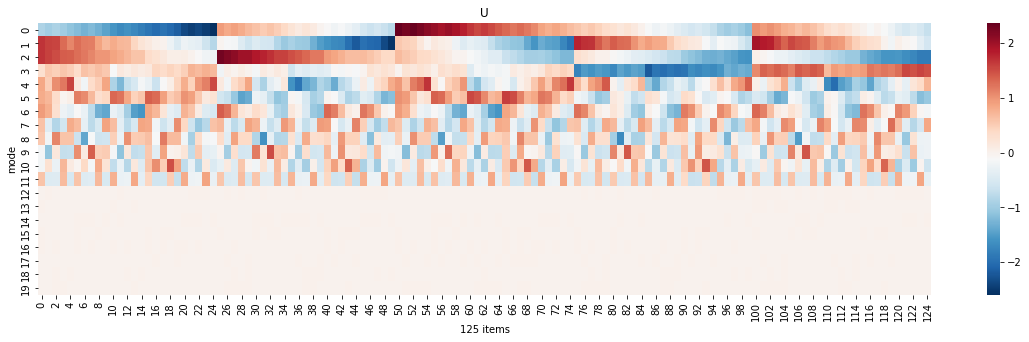

In [115]:
fig, ax = plt.subplots(1, figsize=[20,5])
seaborn.heatmap((u.groupby(['shape', 'color', 'texture']).mean()[range(20)].values * s[:20]).T, ax=ax, cmap='RdBu_r')
ax.set_title('U')
ax.set_ylabel('mode')
ax.set_xlabel('125 items')

SVD shapes: u.shape=(50, 50), s.shape=(50,), v.shape=(50, 128)


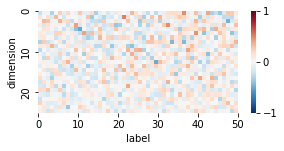

In [17]:
labels = F.pad(F.one_hot(torch.arange(50), 50), pad=(2,0), value=0)
embed_weights = model.transformer.label_embed
embeddings = [embed_weights(x.float().to(model.device)).detach().cpu().numpy() for x in labels]
embeddings = pd.DataFrame(embeddings)
embeddings['layer'] = 'input'
embeddings['label'] = list(range(50))

df = embeddings
u, s, v = svd(df[range(model.hparams.embed_dim)].values)
fig, ax = plt.subplots(1, figsize=[4.2,2.2])

seaborn.heatmap((u*s).T[:25], ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, cbar_kws={'ticks': [-1,0,1]})
ax.set_ylabel('dimension')
ax.set_yticks(range(25)[::10])
_ = ax.set_yticklabels(range(25)[::10])
ax.set_xlabel('label')
ax.set_xticks(range(51)[::10])
_ = ax.set_xticklabels(range(51)[::10], rotation=0)

fig.tight_layout()
# fig.savefig('../figure/v1/%s/svd/input-labelembed-svd-US.pdf'%(runid))

In [48]:
df = embedding_df.copy()
df = df[np.in1d(df['source_probe_target'], ['source','probe'])&(df['layer']=='L0')&(df['item_type']=='item')].reset_index()

u, s, v = svd(df[range(model.hparams.embed_dim)].values)
u = pd.DataFrame(u)
u = pd.concat([df[['layer', 'source_probe_target', 'task', 'shape', 'color', 'texture', 'label']], u], axis=1)
u.to_csv('../figure/v1/%s/svdpca/spjoint-L0-svd-u.csv'%(runid))
pd.DataFrame(s).to_csv('../figure/v1/%s/svdpca/spjoint-L0-svd-s.csv'%(runid))

SVD shapes: u.shape=(30000, 128), s.shape=(128,), v.shape=(128, 128)


In [29]:
embedding_df[(embedding_df['layer']=='L1')&(embedding_df['seq']==0)&(embedding_df['boundary']!='other')]

,seq,task,layer,source_probe_target,item_type,out_pos,boundary,shape,color,texture,...,118,119,120,121,122,123,124,125,126,127
60,0,sort_by_shape_first,L1,source,item,0,begin,0,0,2,...,0.863641,-4.344565,1.624529,-1.568310,-0.774844,-0.729574,-0.421520,2.233699,-4.907624,-0.532505
67,0,sort_by_shape_first,L1,source,item,7,end,0,4,2,...,-0.949477,-0.401932,0.217829,3.312758,-0.789586,-0.978449,1.069607,-0.652507,-1.129803,-1.004385
68,0,sort_by_shape_first,L1,source,item,8,begin,1,0,1,...,0.358951,0.193016,0.243082,-2.083863,3.728377,-2.233163,-0.044970,-1.181762,0.272863,2.190955
71,0,sort_by_shape_first,L1,source,item,11,end,1,4,4,...,0.376900,-2.441979,-2.041122,1.988078,-1.669906,1.729147,-0.146629,1.335088,-1.728699,-1.236582
72,0,sort_by_shape_first,L1,source,item,12,begin,2,1,1,...,2.819073,1.196375,-0.008272,-0.184884,-0.601093,0.182034,-0.933139,-2.676800,-0.732220,-0.395617
79,0,sort_by_shape_first,L1,source,item,19,end,2,4,4,...,0.687693,0.618798,0.070159,1.346166,-0.142206,2.263129,1.828153,1.791533,-1.832273,-0.574073
80,0,sort_by_shape_first,L1,source,item,20,begin,3,1,1,...,0.276256,3.173523,1.397310,-2.487672,1.121879,0.374651,0.683741,0.233720,0.641921,0.833680
82,0,sort_by_shape_first,L1,source,item,22,end,3,4,3,...,3.559174,-1.981234,0.509955,0.728357,-0.298417,-0.337840,3.570309,1.596668,-0.464371,0.479226
83,0,sort_by_shape_first,L1,source,item,23,begin,4,0,4,...,-0.391837,3.021768,0.468574,2.467885,0.727732,-1.318221,-1.122229,2.482436,-0.632075,2.176345
89,0,sort_by_shape_first,L1,source,item,29,end,4,4,3,...,0.826832,-1.307825,-0.315861,0.902944,1.580942,-1.168674,3.704505,0.198359,-3.451302,1.488323


In [56]:
df = embedding_df

df = df[np.in1d(df['source_probe_target'], ['probe','target'])&(df['layer']=='L1')&(df['item_type']=='item')].reset_index()

u, s, v = svd(df[range(model.hparams.embed_dim)].values.T, n_comp=128)
u = pd.DataFrame(u)
v = pd.DataFrame(v.T)
v = pd.concat([df[['source_probe_target','task', 'shape', 'color', 'texture', 'label']], v], axis=1)
v['layer'] = 'L1'
# v.to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-v.csv'%(runid))
# pd.DataFrame(s).to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-s.csv'%(runid))

full SVD shapes: u.shape=(128, 128), s.shape=(128,), v.shape=(128, 30000)
truncated SVD shapes: u.shape=(128, 128), s.shape=(128,), v.shape=(128, 30000)


In [57]:
df = embedding_df

boundary_items = ( (df['source_probe_target']=='probe')&(df['boundary']=='end')&(df['out_pos']!=29) ) | \
                 ( (df['source_probe_target']=='target')&(df['boundary']=='begin')&(df['out_pos']!=0) )
df = df[np.in1d(df['source_probe_target'], ['probe','target'])&(df['layer']=='L1')&(df['item_type']=='item')&boundary_items].reset_index()

u, s, v = svd(df[range(model.hparams.embed_dim)].values.T, n_comp=128)
u = pd.DataFrame(u)
v = pd.DataFrame(v.T)
v = pd.concat([df[['source_probe_target','task', 'shape', 'color', 'texture', 'label']], v], axis=1)
v['layer'] = 'L1'
# v.to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-v-boundary.csv'%(runid))
# pd.DataFrame(s).to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-s-boundary.csv'%(runid))

full SVD shapes: u.shape=(128, 128), s.shape=(128,), v.shape=(128, 3988)
truncated SVD shapes: u.shape=(128, 128), s.shape=(128,), v.shape=(128, 3988)


In [13]:
# create two-item batches
fake_batch = {}
N = 5000

seqs = []
labels = []
for i in range(N):
    # randomly sample two items (sorted)
    x = np.sort(np.random.choice(np.arange(125), size=2, replace=False))
    seq = torch.cat((torch.tensor([1,0]+[0]*15).unsqueeze(0), all_items_multihot[x], torch.tensor([0,1]+[0]*15).unsqueeze(0)))
    seqs.append(seq)
    # randomly sample two labels
    x = np.sort(np.random.choice(np.arange(50), size=2, replace=False))
    label = torch.cat((torch.tensor([1,0]+[0]*50).unsqueeze(0), all_labels[x], torch.tensor([0,1]+[0]*50).unsqueeze(0)))
    labels.append(label)
seqs = torch.stack(seqs)
labels = torch.stack(labels)

fake_batch['seq'] = seqs.clone()
fake_batch['out_seq'] = seqs.clone()
fake_batch['random_label'] = labels.clone()
fake_batch['sorted_label'] = labels.clone()
sort_idx = torch.cat((torch.tensor([1,0]+[0]*50).unsqueeze(0), all_labels[[0,1]], torch.tensor([0,1]+[0]*50).unsqueeze(0)))
fake_batch['sort_idx'] = repeat(sort_idx, 'n d -> b n d', b=N)
fake_batch = utils.batch_to_device(fake_batch, model.device, except_keys=[])

In [14]:
with torch.no_grad():
    result_dict = model.forward(fake_batch)
    loss_dict, acc_dict = model._calc_loss_acc(result_dict)
loss_dict, acc_dict

({'item_loss': tensor(2.2146, device='cuda:5'),
  'label_loss': tensor(1.8508, device='cuda:5')},
 {'item_acc': tensor(0.9647, device='cuda:5'),
  'label_acc': tensor(0.9504, device='cuda:5')})

In [15]:
encoded_reps = model.get_encoded_reps(fake_batch, batch_processed=False, teacher_forcing=True)
print(encoded_reps['input_embed'].shape)
print(encoded_reps['attn_embed'].shape)
tasks = ['sort_by_shape_first'] * N
embedding_df = embedding_matrix_to_dataframe(tasks, model, fake_batch, encoded_reps)

torch.Size([5000, 6, 128])
torch.Size([2, 5000, 6, 128])


In [40]:
df = embedding_df.copy()
# select the same representation twice
df = df[(df['layer']=='L1')&(df['source_probe_target'].values=='probe')&(df['out_pos'].values==0)].reset_index()
# equivalent with ((df['source_probe_target'].values=='target') & (df['out_pos'].values==1))

u, s, v = svd(df[range(model.hparams.embed_dim)].values)
u = pd.DataFrame(u)
u_probe = pd.concat([df[['layer', 'source_probe_target','task', 'shape', 'color', 'texture', 'label']], u.copy()], axis=1)

df = embedding_df.copy()
df = df[(df['layer']=='L1')&(df['source_probe_target'].values=='target')&(df['out_pos'].values==1)].reset_index()
u_target = pd.concat([df[['layer', 'source_probe_target','task', 'shape', 'color', 'texture', 'label']], u.copy()], axis=1)

u = pd.concat([u_probe, u_target]).reset_index()
# u.to_csv('../figure/v1/%s/svdpca/ptjoint-L1-svd-u-seqlen=2.csv'%(runid))
# pd.DataFrame(s).to_csv('../figure/v1/%s/svdpca/ptjoint-L1-svd-s-seqlen=2.csv'%(runid))

SVD shapes: u.shape=(5000, 128), s.shape=(128,), v.shape=(128, 128)


In [25]:
runid

'8goxw4zl'

PCA

In [32]:
def project_embedding_to_lowdim(df, dr_spec, verbose=False):
    result = {}

    for layer in ['input', 'L0', 'L1']:

        if verbose: print('layer: ', layer)

        subdf = df[(df['layer']==layer)&(df['item_type']=='item')&np.in1d(df['source_probe_target'], ['source', 'probe'])]
        subdf = subdf.groupby(['shape', 'color', 'texture']).mean().reset_index()
        pca = sklearn.decomposition.PCA(n_components=dr_spec['n_comp'])
        lowdim_embed = pca.fit_transform(subdf[range(model.hparams.embed_dim)].values)
        if verbose: print('var explained:', pca.explained_variance_ratio_[:3])
        subdf['PC1'] = lowdim_embed[:,0]
        subdf['PC2'] = lowdim_embed[:,1]
        subdf['PC3'] = lowdim_embed[:,2]
        result['%s-spjoint'%layer] = subdf

        for sqtype in ['source', 'probe', 'target']:

            subdf = df[(df['layer']==layer)&(df['item_type']=='item')&(df['source_probe_target']==sqtype)]
            subdf = subdf.groupby(['shape', 'color', 'texture']).mean().reset_index()
            pca = sklearn.decomposition.PCA(n_components=dr_spec['n_comp'])
            lowdim_embed = pca.fit_transform(subdf[range(model.hparams.embed_dim)].values)
            if verbose: print('var explained:', pca.explained_variance_ratio_[:3])
            subdf['PC1'] = lowdim_embed[:,0]
            subdf['PC2'] = lowdim_embed[:,1]
            subdf['PC3'] = lowdim_embed[:,2]
            result['%s-%s'%(layer, sqtype)] = subdf
    
    return result

def plot_points(ax, df_plot, shapes, colors, edge_colors, marker_size, 
                hide_ticks=False, dim=3, axval=None, rotate=(30, 300)):

    if dim == 3:
        ax.view_init(*rotate)

    for index, row in df_plot.iterrows():
        if dim == 2:
            ax.scatter(row['PC1'], row['PC2'], marker=shapes[index], color=colors[index], edgecolor=edge_colors[index], s=marker_size, alpha=0.6)
        else:
            ax.scatter(row['PC1'], row['PC2'], row['PC3'], marker=shapes[index], color=colors[index], edgecolor=edge_colors[index], s=marker_size, alpha=0.6)
    if axval is not None:
        ax.set_xlim(-axval, axval)
        ax.set_ylim(-axval, axval)

    if dim == 2:
        if hide_ticks:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        else:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
    
    if dim == 3:
        if axval is not None:
            ax.set_zlim(-axval, axval)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        if hide_ticks:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax.tick_params(axis='z', which='both', left=False, labelleft=False)
        else:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            # ax.set_zlabel('PC3')

def visualize_lowdim_embedding(df_plot, figsize, dim, axval, edge_colors, **kwargs):

    def int_to_shape(s):
        return ['o', '^', 's', 'p', 'X'][s]

    def int_to_color(c):
        return ['#ff8c69','#ff6996','#de69ff','#697dff','#69daff'][c]

    def int_to_texture(t, c):
        dark_colors = ['#a35943', '#a3415f', '#8b3fa1', '#424fa1', '#4289a1']
        return utils.discrete_color_gradient('#ffffff', dark_colors[c], 5)[t]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1) if dim==2 else fig.add_subplot(1, 1, 1, projection='3d')

    # visuzlize
    df_plot = df_plot.reset_index()
    shapes = [int_to_shape(s) for s in df_plot['shape'].values]
    colors = [int_to_color(c) for c in df_plot['color'].values]
    edge_colors = colors if not edge_colors else [int_to_texture(t, c=df_plot['color'].values[i]) for i, t in enumerate(df_plot['texture'].values)]
    plot_points(ax, df_plot, shapes, colors, edge_colors, dim=dim, axval=axval, **kwargs)

    fig.tight_layout()
    if dim==3: plt.subplots_adjust(wspace=-0.1)
    return fig

In [25]:
dr_spec = {'method': 'pca', 'n_comp': 3}
lowdim_embeddings = project_embedding_to_lowdim(embedding_df, dr_spec=dr_spec, verbose=True)

layer:  input
var explained: [0.16063298 0.13826033 0.12777206]
var explained: [0.16063298 0.13826033 0.12777206]
var explained: [0.16063298 0.13826033 0.12777206]
var explained: [0.24996984 0.21542427 0.15355632]
layer:  L0
var explained: [0.18405694 0.16184981 0.12798384]
var explained: [0.19084615 0.1622056  0.13138284]
var explained: [0.17349176 0.15649569 0.12136356]
var explained: [0.24859798 0.2193232  0.16670938]
layer:  L1
var explained: [0.15713672 0.11072001 0.10544473]
var explained: [0.14195263 0.111618   0.09121129]
var explained: [0.13191687 0.12271146 0.10028512]
var explained: [0.09637634 0.09332538 0.08855198]


In [26]:
lowdim_embeddings.keys()

dict_keys(['input-spjoint', 'input-source', 'input-probe', 'input-target', 'L0-spjoint', 'L0-source', 'L0-probe', 'L0-target', 'L1-spjoint', 'L1-source', 'L1-probe', 'L1-target'])

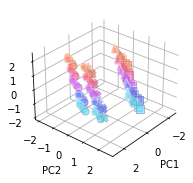

In [48]:
fig = visualize_lowdim_embedding(df_plot=lowdim_embeddings['input-spjoint'], figsize=[2.5,2.5], dim=3,
                                 axval=None, edge_colors=True, rotate=(30, 40), marker_size=50, hide_ticks=False)
# fig.savefig('../figure/v1/%s/input-spjoint-feature-pca.pdf'%(runid))

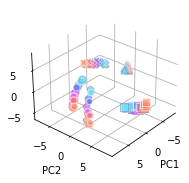

In [47]:
fig = visualize_lowdim_embedding(df_plot=lowdim_embeddings['L0-spjoint'], figsize=[2.5,2.5], dim=3,
                                 axval=None, edge_colors=True, rotate=(30, 40), marker_size=50, hide_ticks=False)
# fig.savefig('../figure/v1/%s/L0-spjoint-feature-pca.pdf'%(runid))

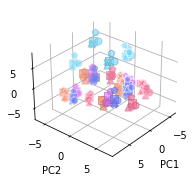

In [49]:
fig = visualize_lowdim_embedding(df_plot=lowdim_embeddings['L1-target'], figsize=[2.5,2.5], dim=3,
                                 axval=None, edge_colors=True, rotate=(30, 40), marker_size=50, hide_ticks=False)
# fig.savefig('../figure/v1/%s/L1-target-feature-pca.pdf'%(runid))

In [94]:
lowdim_embeddings.keys()

dict_keys(['input-spjoint', 'input-source', 'input-probe', 'input-target', 'L0-spjoint', 'L0-source', 'L0-probe', 'L0-target', 'L1-spjoint', 'L1-source', 'L1-probe', 'L1-target'])

In [101]:
for angle in range(0,360,10):
    fig = visualize_lowdim_embedding(data={k: lowdim_embeddings[k] for k in lowdim_embeddings if 'target' in k}, figsize=[12,4], 
                                     dim=3, axval=None, edge_colors=True, rotate=(30, angle), marker_size=120, hide_ticks=True)
    fig.savefig('../figure/v1/%s/rotate/target_pca/%03d.pdf'%(runid, angle))
    plt.close()
# then run convert -delay 40 *.pdf source_pca.gif in bash

decoding output token

In [155]:
# how much does input embedding transfer to output decoding?
hold_val_seq = 375

for feature in ['shape', 'color', 'texture', 'itemnum']:

    df = embedding_df[embedding_df['item_type']=='item']
    df['itemnum'] = df['shape'].values*25 + df['color'].values*5 + df['texture'].values

    train_X = df[(df['source_probe_target']=='source')&(df['layer']=='input')&(df['seq']<hold_val_seq)][range(model.hparams.embed_dim)]
    train_y = df[(df['source_probe_target']=='source')&(df['layer']=='input')&(df['seq']<hold_val_seq)][feature]
    decoder = sklearn.linear_model.LogisticRegression(C=1)
    decoder.fit(train_X, train_y)
    val_X = df[(df['source_probe_target']=='source')&(df['layer']=='input')&(df['seq']>=hold_val_seq)][range(model.hparams.embed_dim)]
    val_y = df[(df['source_probe_target']=='source')&(df['layer']=='input')&(df['seq']>=hold_val_seq)][feature]
    print('extracting %s on input embedding:  train acc = %.3f, val acc = %.3f'%(feature, decoder.score(train_X, train_y), decoder.score(val_X, val_y)))

    X = df[(df['source_probe_target']=='target')&(df['layer']=='L1')][range(model.hparams.embed_dim)]
    y = df[(df['source_probe_target']=='target')&(df['layer']=='L1')][feature]
    print('    transfer to target %s decoding: %.3f' % (feature, decoder.score(X, y)))

extracting shape on input embedding:  train acc = 1.000, val acc = 1.000
    transfer to target shape decoding: 0.328
extracting color on input embedding:  train acc = 1.000, val acc = 1.000
    transfer to target color decoding: 0.181
extracting texture on input embedding:  train acc = 1.000, val acc = 1.000
    transfer to target texture decoding: 0.056
extracting itemnum on input embedding:  train acc = 1.000, val acc = 1.000
    transfer to target itemnum decoding: 0.001


In [ ]:
accs = defaultdict(list)
hold_val_seq = 375

for runid in max_val_acc_df[max_val_acc_df['arch']=='D2H1']['runid'].values:
    
    # load max val acc ckpt
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
    # get encoded token representations
    encoded_reps = model.get_encoded_reps(batch, batch_processed=False, teacher_forcing=True)
    embedding_df = embedding_matrix_to_dataframe(tasks, model, batch, encoded_reps)

    df = embedding_df[(embedding_df['source_probe_target']=='target')&(embedding_df['item_type']=='item')]
    df['itemnum'] = df['shape'].values*25 + df['color'].values*5 + df['texture'].values

    for layer, feature in it.product(['input', 'L0', 'L1'], ['shape', 'color', 'texture', 'itemnum']):
        train_X = df[(df['layer']==layer)&(df['seq']<hold_val_seq)][range(model.hparams.embed_dim)]
        train_y = df[(df['layer']==layer)&(df['seq']<hold_val_seq)][feature]
        val_X = df[(df['layer']==layer)&(df['seq']>=hold_val_seq)][range(model.hparams.embed_dim)]
        val_y = df[(df['layer']==layer)&(df['seq']>=hold_val_seq)][feature]
        decoder = sklearn.linear_model.LogisticRegression(C=1)
        decoder.fit(train_X, train_y)

        accs['runid'].append(runid)
        accs['layer'].append(layer)
        accs['feature'].append(feature)
        accs['train_acc'].append(decoder.score(train_X, train_y))
        accs['val_acc'].append(decoder.score(val_X, val_y))

In [74]:
accs = pd.DataFrame(accs)
pkl.dump(accs, open('single_task_decoding_acc.pkl', 'wb'))

In [58]:
accs = pkl.load(open('single_task_decoding_acc.pkl', 'rb'))
accs = accs.groupby(['layer', 'feature']).agg([np.mean, sp.stats.sem]).reset_index()

In [90]:
[accs[(accs['layer']==layer)&(accs['feature']=='shape')]['val_acc','mean'].values[0] for layer in ['input', 'L0', 'L1']]

[0.9216, 0.9991333333333333, 1.0]

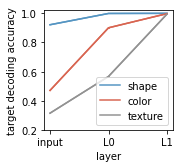

In [114]:
fig, ax = plt.subplots(1, figsize=[2.6,2.4])

# colors = ['#EAC8CA', '#CFA5B4', '#616283']
colors = ['#5595C2', '#D86551', '#929292']

for f, feature in enumerate(['shape', 'color', 'texture']):
    vals = [accs[(accs['layer']==layer)&(accs['feature']==feature)]['val_acc','mean'].values[0] for layer in ['input', 'L0', 'L1']]
    errs = [accs[(accs['layer']==layer)&(accs['feature']==feature)]['val_acc','sem'].values[0] for layer in ['input', 'L0', 'L1']]
    ax.plot([0,1,2], vals, color=colors[f], label=feature)
    ax.errorbar([0,1,2], vals, yerr=errs, color=colors[f])

ax.legend(loc='lower right', ncol=1)
ax.set_ylabel('target decoding accuracy')
ax.set_ylim([0.2, 1.02])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['input', 'L0', 'L1'])
ax.set_xlabel('layer')

fig.tight_layout()
# fig.savefig('../figure/v1/single_task_D2H1_rep_decode.pdf')